Neste tópico, iremos preparar nossos dados para modelagem, criando pipeline para garatir que qualquer tipo de dadaset tenha esse problema, tenha uma boa permormance. Diante disto utilizaremos o o modelo RandomForestClassifier, é um modelo simples, que cria várias árvores de decisões aleatórias(Bootstrap) e as combinam para obter uma melhor avaliação possível para o modelo, além de ser mais estável, e seus hiperparâmetros garantem um bom resultado para predição, além de ser um modelo robusto a outliers. Vale recaltar que o problema trata-se de uma classificação múltipla. 

# Dependências

In [1]:
#Importanto bibliotecas.
#import sys
#!{sys.executable} -m pip install yellowbrick
import warnings 
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cloudpickle
from src.modelagem import preencher_missing_mediana
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import SCORERS
import optuna
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
#Constantes
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_RAW_NAME = 'Safra_2018-2019.csv'
DATA_INTER_PATH = os.path.join('..','data','inter')
DATA_INTER_TEST_NAME = 'test_inter.csv'
DATA_INTER_TRAIN_FT_SELECTION = 'train_inter_ft_selection.csv'
IMG_PATH = os.path.abspath(os.path.join('..','img'))
META_DATA_PATH = os.path.join(DATA_RAW_PATH,'dicionario_tipos.pkl')
#TARGET = 'dano_na_plantacao'

In [3]:
with open(META_DATA_PATH,'rb') as f:
    dicionario_tipo = cloudpickle.load(f)

In [4]:
# DataSet que será utilizado para modelagem, depois da seleção de features.
df_train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_FT_SELECTION), dtype=dicionario_tipo)
#Lendo dados de teste.
df_test = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TEST_NAME), dtype=dicionario_tipo, index_col=0)

In [5]:
df_train.head()

,Semanas_Utilizando,Semanas_Sem_Uso,Estimativa_de_Insetos,Doses_Semana,Categoria_Pesticida,Tipo_de_Cultivo,dano_na_plantacao
0,12.0,19,984,25,2,0,0
1,27.0,7,851,20,2,0,0
2,27.0,0,283,35,3,0,0
3,50.0,0,2542,15,3,0,2
4,14.0,24,850,30,2,0,0


# Criando Pipeline

In [6]:
#Separando as variáveis categóricas e numéricas
variaveis_categoricas = df_train.select_dtypes(include=['object']).columns.tolist()
variaveis_numericas = df_train.select_dtypes(include=['int','float']).columns.tolist()

In [7]:
#Removendo target das variáveis categóricas. 
target = 'dano_na_plantacao'
variaveis_categoricas.remove(target)

In [8]:
pipeline_numerico = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
pipeline_categorico = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                         ('ordinal_encoder', OrdinalEncoder())])

In [9]:
preprocess_pipeline = ColumnTransformer([('pipe_categorico', pipeline_categorico, variaveis_categoricas),
                                ('pipe_numerico', pipeline_numerico, variaveis_numericas)])

In [10]:
# Definindo folds para a validação cruzada estratificada (dados desbalanceados).
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=123)

In [11]:
rf = RandomForestClassifier(random_state=0, class_weight='balanced')
modelo_pipe =  Pipeline(steps =[('preprocessor',preprocess_pipeline),
                                  ('model_rf',rf)])

# Modelagem e Avaliação

Vou basear a análise do modelo no recall, pois queremos que a proporção de positivos reais sejam classificadas corretamente. A escolha da métrica de avaliação, é um passo importante do pipeline de modelagem e deve ser ajustada de acordo com as necessidades levantadas pelo cliente. Pode até mesmo ser uma métrica personalizada.

In [12]:
# Obtendo X e Y para treino e teste.
X = df_train.drop(target,axis=1)
y = df_train[target]

In [13]:
#from sklearn.metrics import classification_report
#print(classification_report(y, modelo_pipe.predict(X))#)

In [14]:
# Score de Validação Cruzada
#cross_validation_results = cross_val_score(modelo_pipe,X,y, cv=cv, scoring = 'recall_weighted')
#print(f'A média de validação cruzada foi: {round(np.mean(cross_validation_results),2)}\nO desvio padrão de validação cruzada foi: {round(np.std(cross_validation_results),2)}')

In [15]:
def fitRF(trial):
    "Train RandomForest Model"

    np.random.seed(123)
# Grid de parametros otimizados
    params ={'model_rf__max_depth': trial.suggest_int('model_rf__max_depth',2,13),
          'model_rf__min_samples_leaf': trial.suggest_int('model_rf__min_samples_leaf',2,33),
          'model_rf__min_samples_split':trial.suggest_int('model_rf__min_samples_split',2,33),
          'model_rf__n_estimators': trial.suggest_int('model_rf__n_estimators',50,300),
          'model_rf__criterion':trial.suggest_categorical('model_rf__criterion',['gini','entropy'])
      }
    earlyStop=20
    modelo_pipe.set_params(**params)


    results = np.mean(cross_val_score(modelo_pipe,X,y, cv=cv, scoring = 'recall_weighted'))

    #score = results.mean()  
    #intervalo(results)
    print(f'SCORE DE RECALL:{results}')
    return results
          

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(fitRF, n_trials=25)
print(study.best_trial)

SCORE DE RECALL:0.6668906250000001


[I 2020-08-07 16:31:30,402] Trial 0 finished with value: 0.6668906250000001 and parameters: {'model_rf__max_depth': 10, 'model_rf__min_samples_leaf': 20, 'model_rf__min_samples_split': 30, 'model_rf__n_estimators': 181, 'model_rf__criterion': 'entropy'}. Best is trial 0 with value: 0.6668906250000001.


SCORE DE RECALL:0.6682343749999999


[I 2020-08-07 16:32:01,457] Trial 1 finished with value: 0.6682343749999999 and parameters: {'model_rf__max_depth': 11, 'model_rf__min_samples_leaf': 23, 'model_rf__min_samples_split': 5, 'model_rf__n_estimators': 273, 'model_rf__criterion': 'gini'}. Best is trial 1 with value: 0.6682343749999999.


SCORE DE RECALL:0.6727812499999999


[I 2020-08-07 16:32:14,476] Trial 2 finished with value: 0.6727812499999999 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 26, 'model_rf__min_samples_split': 20, 'model_rf__n_estimators': 96, 'model_rf__criterion': 'gini'}. Best is trial 2 with value: 0.6727812499999999.


SCORE DE RECALL:0.677359375


[I 2020-08-07 16:32:28,761] Trial 3 finished with value: 0.677359375 and parameters: {'model_rf__max_depth': 2, 'model_rf__min_samples_leaf': 30, 'model_rf__min_samples_split': 22, 'model_rf__n_estimators': 282, 'model_rf__criterion': 'entropy'}. Best is trial 3 with value: 0.677359375.


SCORE DE RECALL:0.661125


[I 2020-08-07 16:32:45,523] Trial 4 finished with value: 0.661125 and parameters: {'model_rf__max_depth': 6, 'model_rf__min_samples_leaf': 8, 'model_rf__min_samples_split': 23, 'model_rf__n_estimators': 194, 'model_rf__criterion': 'entropy'}. Best is trial 3 with value: 0.677359375.


SCORE DE RECALL:0.6707500000000001


[I 2020-08-07 16:32:50,889] Trial 5 finished with value: 0.6707500000000001 and parameters: {'model_rf__max_depth': 4, 'model_rf__min_samples_leaf': 18, 'model_rf__min_samples_split': 13, 'model_rf__n_estimators': 60, 'model_rf__criterion': 'entropy'}. Best is trial 3 with value: 0.677359375.


SCORE DE RECALL:0.659625


[I 2020-08-07 16:33:01,032] Trial 6 finished with value: 0.659625 and parameters: {'model_rf__max_depth': 6, 'model_rf__min_samples_leaf': 16, 'model_rf__min_samples_split': 16, 'model_rf__n_estimators': 111, 'model_rf__criterion': 'gini'}. Best is trial 3 with value: 0.677359375.


SCORE DE RECALL:0.66046875


[I 2020-08-07 16:33:24,897] Trial 7 finished with value: 0.66046875 and parameters: {'model_rf__max_depth': 9, 'model_rf__min_samples_leaf': 25, 'model_rf__min_samples_split': 5, 'model_rf__n_estimators': 228, 'model_rf__criterion': 'gini'}. Best is trial 3 with value: 0.677359375.


SCORE DE RECALL:0.660921875


[I 2020-08-07 16:33:41,538] Trial 8 finished with value: 0.660921875 and parameters: {'model_rf__max_depth': 9, 'model_rf__min_samples_leaf': 20, 'model_rf__min_samples_split': 8, 'model_rf__n_estimators': 155, 'model_rf__criterion': 'gini'}. Best is trial 3 with value: 0.677359375.


SCORE DE RECALL:0.667921875


[I 2020-08-07 16:34:02,255] Trial 9 finished with value: 0.667921875 and parameters: {'model_rf__max_depth': 5, 'model_rf__min_samples_leaf': 26, 'model_rf__min_samples_split': 6, 'model_rf__n_estimators': 275, 'model_rf__criterion': 'entropy'}. Best is trial 3 with value: 0.677359375.


SCORE DE RECALL:0.676828125


[I 2020-08-07 16:34:17,222] Trial 10 finished with value: 0.676828125 and parameters: {'model_rf__max_depth': 2, 'model_rf__min_samples_leaf': 32, 'model_rf__min_samples_split': 33, 'model_rf__n_estimators': 295, 'model_rf__criterion': 'entropy'}. Best is trial 3 with value: 0.677359375.


SCORE DE RECALL:0.67753125


[I 2020-08-07 16:34:32,139] Trial 11 finished with value: 0.67753125 and parameters: {'model_rf__max_depth': 2, 'model_rf__min_samples_leaf': 31, 'model_rf__min_samples_split': 32, 'model_rf__n_estimators': 299, 'model_rf__criterion': 'entropy'}. Best is trial 11 with value: 0.67753125.


SCORE DE RECALL:0.6793124999999999


[I 2020-08-07 16:34:44,514] Trial 12 finished with value: 0.6793124999999999 and parameters: {'model_rf__max_depth': 2, 'model_rf__min_samples_leaf': 33, 'model_rf__min_samples_split': 26, 'model_rf__n_estimators': 242, 'model_rf__criterion': 'entropy'}. Best is trial 12 with value: 0.6793124999999999.


SCORE DE RECALL:0.6726875


[I 2020-08-07 16:34:58,391] Trial 13 finished with value: 0.6726875 and parameters: {'model_rf__max_depth': 3, 'model_rf__min_samples_leaf': 33, 'model_rf__min_samples_split': 28, 'model_rf__n_estimators': 231, 'model_rf__criterion': 'entropy'}. Best is trial 12 with value: 0.6793124999999999.


SCORE DE RECALL:0.6791406249999999


[I 2020-08-07 16:35:10,507] Trial 14 finished with value: 0.6791406249999999 and parameters: {'model_rf__max_depth': 2, 'model_rf__min_samples_leaf': 11, 'model_rf__min_samples_split': 26, 'model_rf__n_estimators': 237, 'model_rf__criterion': 'entropy'}. Best is trial 12 with value: 0.6793124999999999.


SCORE DE RECALL:0.673203125


[I 2020-08-07 16:35:24,389] Trial 15 finished with value: 0.673203125 and parameters: {'model_rf__max_depth': 3, 'model_rf__min_samples_leaf': 10, 'model_rf__min_samples_split': 25, 'model_rf__n_estimators': 231, 'model_rf__criterion': 'entropy'}. Best is trial 12 with value: 0.6793124999999999.


SCORE DE RECALL:0.6596093749999999


[I 2020-08-07 16:35:47,350] Trial 16 finished with value: 0.6596093749999999 and parameters: {'model_rf__max_depth': 7, 'model_rf__min_samples_leaf': 4, 'model_rf__min_samples_split': 27, 'model_rf__n_estimators': 247, 'model_rf__criterion': 'entropy'}. Best is trial 12 with value: 0.6793124999999999.


SCORE DE RECALL:0.67528125


[I 2020-08-07 16:36:02,004] Trial 17 finished with value: 0.67528125 and parameters: {'model_rf__max_depth': 4, 'model_rf__min_samples_leaf': 13, 'model_rf__min_samples_split': 18, 'model_rf__n_estimators': 212, 'model_rf__criterion': 'entropy'}. Best is trial 12 with value: 0.6793124999999999.


SCORE DE RECALL:0.674328125


[I 2020-08-07 16:36:13,038] Trial 18 finished with value: 0.674328125 and parameters: {'model_rf__max_depth': 4, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 25, 'model_rf__n_estimators': 151, 'model_rf__criterion': 'entropy'}. Best is trial 12 with value: 0.6793124999999999.


SCORE DE RECALL:0.6784374999999999


[I 2020-08-07 16:36:26,001] Trial 19 finished with value: 0.6784374999999999 and parameters: {'model_rf__max_depth': 2, 'model_rf__min_samples_leaf': 6, 'model_rf__min_samples_split': 14, 'model_rf__n_estimators': 255, 'model_rf__criterion': 'entropy'}. Best is trial 12 with value: 0.6793124999999999.


SCORE DE RECALL:0.685109375


[I 2020-08-07 16:36:53,651] Trial 20 finished with value: 0.685109375 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 12, 'model_rf__min_samples_split': 30, 'model_rf__n_estimators': 203, 'model_rf__criterion': 'entropy'}. Best is trial 20 with value: 0.685109375.


SCORE DE RECALL:0.6850156249999999


[I 2020-08-07 16:37:21,344] Trial 21 finished with value: 0.6850156249999999 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 12, 'model_rf__min_samples_split': 30, 'model_rf__n_estimators': 202, 'model_rf__criterion': 'entropy'}. Best is trial 20 with value: 0.685109375.


SCORE DE RECALL:0.68309375


[I 2020-08-07 16:37:48,434] Trial 22 finished with value: 0.68309375 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 14, 'model_rf__min_samples_split': 30, 'model_rf__n_estimators': 201, 'model_rf__criterion': 'entropy'}. Best is trial 20 with value: 0.685109375.


SCORE DE RECALL:0.6821718750000001


[I 2020-08-07 16:38:15,638] Trial 23 finished with value: 0.6821718750000001 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 15, 'model_rf__min_samples_split': 30, 'model_rf__n_estimators': 201, 'model_rf__criterion': 'entropy'}. Best is trial 20 with value: 0.685109375.


SCORE DE RECALL:0.678890625


[I 2020-08-07 16:38:37,037] Trial 24 finished with value: 0.678890625 and parameters: {'model_rf__max_depth': 12, 'model_rf__min_samples_leaf': 12, 'model_rf__min_samples_split': 33, 'model_rf__n_estimators': 160, 'model_rf__criterion': 'entropy'}. Best is trial 20 with value: 0.685109375.


FrozenTrial(number=20, value=0.685109375, datetime_start=datetime.datetime(2020, 8, 7, 16, 36, 26, 4239), datetime_complete=datetime.datetime(2020, 8, 7, 16, 36, 53, 651261), params={'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 12, 'model_rf__min_samples_split': 30, 'model_rf__n_estimators': 203, 'model_rf__criterion': 'entropy'}, distributions={'model_rf__max_depth': IntUniformDistribution(high=13, low=2, step=1), 'model_rf__min_samples_leaf': IntUniformDistribution(high=33, low=2, step=1), 'model_rf__min_samples_split': IntUniformDistribution(high=33, low=2, step=1), 'model_rf__n_estimators': IntUniformDistribution(high=300, low=50, step=1), 'model_rf__criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=20, state=TrialState.COMPLETE)


In [17]:
modelo_pipe.set_params(**study.best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipe_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Categoria_Pesticida',
                                                   'Tipo_de_Cultivo']),
                                                 ('pipe_numerico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Semanas_Utilizando',
                                                   'Semanas_Sem_Uso',
 

In [18]:
modelo_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipe_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Categoria_Pesticida',
                                                   'Tipo_de_Cultivo']),
                                                 ('pipe_numerico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Semanas_Utilizando',
                                                   'Semanas_Sem_Uso',
 

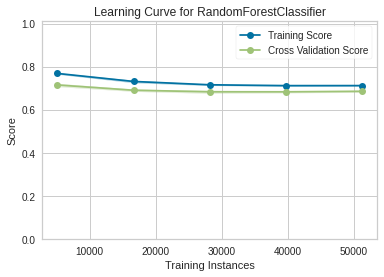

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [19]:
visualizer = LearningCurve(modelo_pipe, cv=cv, scoring='recall_weighted', n_jobs=4, random_state = 123)
visualizer.fit(X, y)    
plt.ylim((0,1.01)) # Fit the data to the visualizer
visualizer.show() 


In [ ]:
train_sizes = [1000, 2000, 5000, 6000]
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#plot_learning_curve(LogisticRegression(), X, y, cv=cv, n_jobs=24, train_sizes=train_sizes)
display(plot_learning_curve(XGBClassifier(), "Learning curve", X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=24).show())

In [69]:
cross_validation_results

array([nan, nan, nan, nan, nan])

In [48]:
modelo_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipe_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Tipo_de_Cultivo',
                                                   'Categoria_Pesticida']),
                                                 ('pipe_numerico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Semanas_Utilizando',
                                                   'Estimativa_de_Inset

In [70]:
#df_test['Tipo_de_Cultivo'] = df_test['Tipo_de_Cultivo'].astype('float').apply(lambda x: str(x))
#df_test['Categoria_Pesticida'] = df_test['Categoria_Pesticida'].astype('float').apply(lambda x: str(x))

In [71]:
y_pred_test = modelo_pipe.predict(df_test.drop(target,axis=1))

In [80]:
from sklearn.metrics import recall_score
recall_score(df_test['dano_na_plantacao'], y_pred_test,average='weighted')

0.6964375

In [75]:
y_pred_test

array(['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0'], dtype=object)

In [79]:
df_test['dano_na_plantacao'] = df_test['dano_na_plantacao'].astype('float').apply(lambda x: str(x))

In [37]:
df_train['dano_na_plantacao'].value_counts(normalize=True)

0.0    0.837804
1.0    0.136176
2.0    0.026020
Name: dano_na_plantacao, dtype: float64